In [ ]:
from utils.common_imports import *  # Importing everything from common_imports
from utils.data_utils import set_reproducibility, prepare_datasets, create_data_loaders, extract_embeddings
from utils.model_utils import train_model, compute_metrics, initialize_nn_and_training_components, device
from utils.plot_utils import plot_training_history, plot_confusion_matrix, compute_and_plot_per_class_accuracy, visualize_original_and_augmented_data, plot_tsne

# Use the custom style
plt.style.use('latex_style.mplstyle')


/Users/shahabnasiri/Library/Mobile Documents/com~apple~CloudDocs/All/CAMBRIDGE/M1/m1_ml_for_dis/sy475/mnist_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare Datasets and Ensure Reproducibility

- Define parameters for dataset preparation, such as the percentage of data to use, validation size, and test size.
- Ensure reproducibility by setting seeds for Python, NumPy, and PyTorch.
- Prepare the datasets (`train_dataset`, `val_dataset`, `test_dataset`) using the `prepare_datasets` function.
- Print the sizes of the training, validation, and test datasets to verify the splits.


In [2]:
data_percentage = 1.0
validation_size = 8000
test_size = 2000


set_reproducibility()
# Prepare datasets
train_dataset, val_dataset, test_dataset = prepare_datasets(
    mode="56x28",   # Specify paired 56x28 dataset
    data_percentage=data_percentage,  # Use 100% of the data for training (can adjust if needed)
    validation_size=validation_size,  # Default validation size
    test_size=test_size         # Default test size
)


# Print dataset sizes
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Training size: 120000
Validation size: 8000
Test size: 2000


### Visualize Original and Augmented Data

- Extract a subset of original and augmented data from the `train_dataset`.
- Use the `visualize_original_and_augmented_data` function to plot and compare a few examples of original and augmented images.
- Specify the number of image pairs (`n`) and the correct image shape (`56x28`) for visualization.


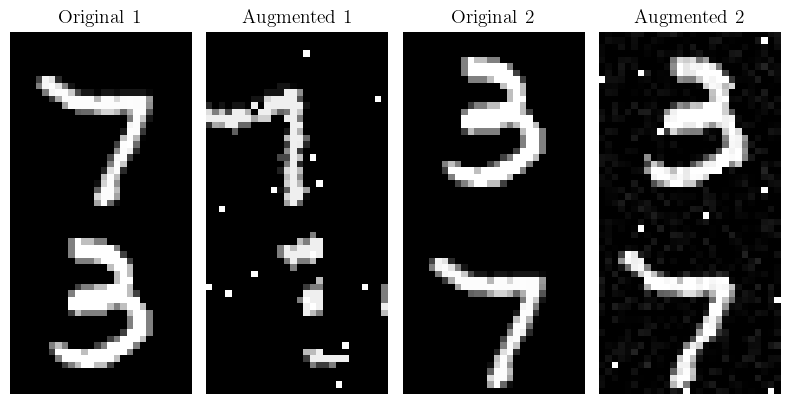

In [ ]:
# Visualize original and augmented data
train_original_data, train_original_labels = train_dataset[:int(60000*data_percentage)]
train_augmented_data, augmented_labels = train_dataset[int(60000*data_percentage):]

visualize_original_and_augmented_data(
    original_images=train_original_data[:5].numpy(),  
    augmented_images=train_augmented_data[:5].numpy(),
    n = 2,
    image_shape=(56, 28)  
)



### Plot Normalized Label Distribution

- Visualize the normalized label distribution for the training, validation, and test datasets.
- Extract labels from each dataset and calculate the proportions of each label to show their relative frequencies.
- Plot the distributions on a single bar chart for comparison, with separate bars for training, validation, and test datasets.


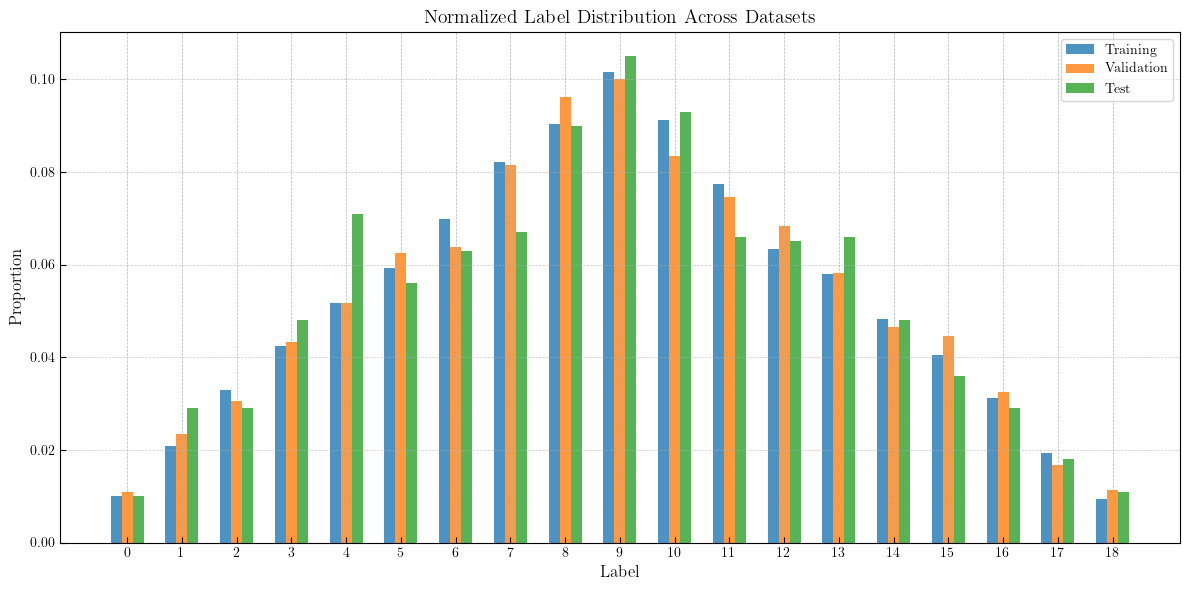

In [ ]:
def plot_normalized_label_distribution(train_dataset, val_dataset, test_dataset):

    # Extract labels
    train_labels = np.array([label.numpy() for _, label in train_dataset])
    val_labels = np.array([label.numpy() for _, label in val_dataset])
    test_labels = np.array([label.numpy() for _, label in test_dataset])

    # Count occurrences and normalize
    unique_labels = np.arange(len(np.unique(train_labels)))  
    train_counts = np.array([np.sum(train_labels == label) for label in unique_labels])
    val_counts = np.array([np.sum(val_labels == label) for label in unique_labels])
    test_counts = np.array([np.sum(test_labels == label) for label in unique_labels])

    # Normalize counts to proportions
    train_counts_normalized = train_counts / train_counts.sum()
    val_counts_normalized = val_counts / val_counts.sum()
    test_counts_normalized = test_counts / test_counts.sum()

    # Plot all distributions on the same graph
    plt.figure(figsize=(12, 6))
    plt.bar(unique_labels - 0.2, train_counts_normalized, width=0.2, label="Training", align="center", alpha=0.8)
    plt.bar(unique_labels, val_counts_normalized, width=0.2, label="Validation", align="center", alpha=0.8)
    plt.bar(unique_labels + 0.2, test_counts_normalized, width=0.2, label="Test", align="center", alpha=0.8)

    # Add labels, title, and legend
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.title("Normalized Label Distribution Across Datasets", fontsize=14)
    plt.xticks(unique_labels, fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig("label_distribution.pdf", format="pdf")

    plt.show()

plot_normalized_label_distribution(train_dataset, val_dataset, test_dataset)


### Run Optuna Hyperparameter Optimization

- Use Optuna to optimize the hyperparameters of the model, dynamically building network architectures.
- Key steps in this function:
  1. **Dynamic Architecture Search**:
     - The number of layers (`num_layers`) and neurons per layer (`initial_neurons`) are dynamically adjusted for each trial.
     - A reduction factor determines the size of subsequent layers.
  2. **Hyperparameter Suggestions**:
     - Hyperparameters like dropout rate, learning rate, batch size, activation function, and optimizer are suggested based on the provided search space.
  3. **Training and Validation**:
     - Data loaders are created, and the model is trained with the suggested configuration.
     - Validation accuracy is recorded for each trial.
  4. **Model Saving**:
     - The model's state dictionary and training history are saved for each trial.
  5. **Pruning**:
     - Trials with insufficient improvement are pruned to speed up optimization.

- An Optuna study is created with:
  - **Direction**: Maximizing validation accuracy.
  - **Pruner**: Median pruner to stop underperforming trials.
  - **Sampler**: TPE sampler for efficient hyperparameter sampling.

- Finally, the study is run for the specified number of trials, and the best hyperparameter configuration is returned.


In [5]:
def run_optuna_study_dynamic(hyperparameter_space: dict, n_trials: int, epochs: int, optimizer_fixed: str = None) -> optuna.Study:

    def optimize_hyperparameters(trial: optuna.Trial) -> float:
        # Dynamic architecture search
        num_layers = trial.suggest_int("num_layers", 2, 8)  # Allow between 2 and 8 layers
        initial_neurons = trial.suggest_int("initial_neurons", 512, 2048)
        reduction_factor = trial.suggest_float("reduction_factor", 0.5, 0.9)  # Reduction factor between 50% and 90%

        # Build hidden layer sizes
        hidden_sizes = [int(initial_neurons * (reduction_factor**i)) for i in range(num_layers)]

        # Suggest other hyperparameters
        dropout_rate = trial.suggest_float("dropout_rate", *hyperparameter_space["dropout_rate_range"])
        learning_rate = trial.suggest_loguniform("lr", *hyperparameter_space["learning_rate_range"])
        batch_size = trial.suggest_categorical("batch_size", hyperparameter_space["batch_size_options"])
        activation_function = trial.suggest_categorical("activation_function", hyperparameter_space["activation_function_options"])
        optimizer_name = optimizer_fixed or trial.suggest_categorical("optimizer", hyperparameter_space["optimizer_options"])
        
        # Configure settings for the experiment
        config = {
            "hidden_sizes": hidden_sizes,
            "dropout_rate": dropout_rate,
            "activation_function": activation_function,
            "optimizer": optimizer_name,
            "lr": learning_rate,
        }

        print(f"Trial #{trial.number}: {config}")

        # Create data loaders
        train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)

        # Initialize model, criterion, optimizer, and scheduler
        model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)

        # Train the model with pruning
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=epochs, trial=trial)

        # Use validation accuracy directly from history
        val_accuracy = max(history["val_acc"])

        # Save trial details
        model_path = f"model_trial_{trial.number}.pth"
        torch.save(model.state_dict(), model_path)
        trial.set_user_attr("model_path", model_path)
        trial.set_user_attr("history", history)

        return val_accuracy

    # Create and run the Optuna study
    study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(),
    sampler=optuna.samplers.TPESampler(seed=42)
)

    study.optimize(optimize_hyperparameters, n_trials=n_trials)

    return study


### Evaluate and Plot the Best Model

- **Retrieve the Best Trial**:
  - Extract the best hyperparameters and reconstruct the `hidden_sizes` for the network architecture.
  

- **Reconstruct and Load the Best Model**:
  - Use the optimal hyperparameters to reinitialize the model and load the saved weights from the best trial.

- **Evaluate the Model**:
  - Create a test DataLoader using the batch size from the best trial.
  - Compute metrics (e.g., test loss, accuracy) for the test dataset.

- **Generate Plots**:
  - Plot the training history (loss and accuracy over epochs) using `plot_training_history`.
  - Visualize the confusion matrix to compare predictions with ground truths.
  - Compute and plot per-class accuracy to assess the model's performance on individual classes.

- **Display Key Metrics**:
  - Print validation and test accuracy for the best model, showcasing its overall performance.


In [ ]:
def evaluate_and_plot_best_model(study: optuna.Study, train_dataset: TensorDataset, val_dataset: TensorDataset,
                                test_dataset: TensorDataset, num_classes: int = 19) -> tuple:

    # Retrieve the best trial and display its parameters
    best_trial = study.best_trial

    # Reconstruct `hidden_sizes` dynamically
    num_layers = best_trial.params["num_layers"]
    initial_neurons = best_trial.params["initial_neurons"]
    reduction_factor = best_trial.params["reduction_factor"]
    hidden_sizes = [int(initial_neurons * (reduction_factor**i)) for i in range(num_layers)]
    hidden_sizes = [size for size in hidden_sizes if size > 16]  # Exclude very small layers

    # Print the best parameters with hidden layer sizes
    print("Global Best Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    print(f"  Computed Hidden Sizes: {hidden_sizes}")

    # Reconstruct the configuration from the best trial
    config = {
        "hidden_sizes": hidden_sizes,
        "dropout_rate": best_trial.params["dropout_rate"],
        "activation_function": best_trial.params["activation_function"],
        "optimizer": best_trial.params.get("optimizer", "Adam"),
        "lr": best_trial.params.get("lr", 0.001),
    }

    # Initialize the best model and load the saved weights
    best_model, criterion, _, _ = initialize_nn_and_training_components(config, input_size=1568, output_size=num_classes)
    best_model.load_state_dict(torch.load(best_trial.user_attrs["model_path"]))
    best_model.eval()

    # Create test data loader
    _, _, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, best_trial.params["batch_size"])

    # Compute evaluation metrics
    metrics = compute_metrics(best_model, test_loader, criterion)
    predictions, ground_truths = metrics["predictions"], metrics["ground_truths"]

    # Plot training history
    plot_training_history(best_trial.user_attrs["history"])

    # Visualize confusion matrix
    plot_confusion_matrix(predictions, ground_truths, [f"{i}" for i in range(num_classes)])

    # Compute and visualize per-class accuracy
    per_class_accuracy = compute_and_plot_per_class_accuracy(predictions, ground_truths, num_classes)

    # Display validation and test accuracy
    val_acc = max(best_trial.user_attrs["history"]["val_acc"])
    print(f"Best Model Validation Accuracy: {val_acc:.2f}%")
    print(f"Best Model Test Accuracy: {metrics['accuracy']:.2f}%")

    return best_model, {"metrics": metrics, "per_class_accuracy": per_class_accuracy}


### Run Hyperparameter Optimization and Evaluate the Best Model

- **Hyperparameter Space**:
  - Define the search space for key hyperparameters, including dropout rate, learning rate, batch size, activation function, and optimizer.

- **Run Optuna Study**:
  - Use `run_optuna_study_dynamic` to perform hyperparameter optimization with Optuna.
  - Specify the number of trials (`N_TRIALS`) and epochs (`EPOCHS`) for each trial.

- **Evaluate the Best Model**:
  - Use `evaluate_and_plot_best_model` to retrieve the best model from the study.
  - Generate evaluation plots (e.g., training history, confusion matrix, per-class accuracy).
  - Display the global best hyperparameters found by the optimization process.


In [ ]:
HYPERPARAMETER_SPACE = {
    "dropout_rate_range": (0.1, 0.5),
    "learning_rate_range": (1e-4, 1e-1),
    "batch_size_options": [32, 64],
    "activation_function_options": ["ReLU", "Tanh", "Sigmoid"],
    "optimizer_options": ["Adam", "SGD", "RMSprop"],
}

N_TRIALS = 20
EPOCHS = 25

# Run dynamic architecture search
global_study_dynamic = run_optuna_study_dynamic(
    hyperparameter_space=HYPERPARAMETER_SPACE,
    n_trials=N_TRIALS,
    epochs=EPOCHS,    
)



[I 2024-12-05 22:14:34,232] A new study created in memory with name: no-name-f83ed7ce-175d-4be5-b173-80bc772d89f2


Trial #0: {'hidden_sizes': [1973, 1564, 1240, 983], 'dropout_rate': 0.3394633936788147, 'activation_function': 'ReLU', 'optimizer': 'SGD', 'lr': 0.00029380279387035364}
Using 7 workers for DataLoader.


/var/folders/ng/cyld_kr91t5dmh88m5ckk_d00000gn/T/ipykernel_40682/3575043259.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", *hyperparameter_space["learning_rate_range"])
[I 2024-12-05 22:15:48,846] Trial 0 pruned. 


Pruning trial 0: Validation accuracy 49.84% is below threshold after first epoch.
Trial #1: {'hidden_sizes': [791, 453, 260], 'dropout_rate': 0.2216968971838151, 'activation_function': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.003752055855124282}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 1.7705, Val Loss: 0.6185, Train Acc: 43.96%, Val Acc: 82.85%
Epoch 2/25, Train Loss: 1.1699, Val Loss: 0.4127, Train Acc: 64.15%, Val Acc: 88.22%
Epoch 3/25, Train Loss: 0.9550, Val Loss: 0.3444, Train Acc: 71.11%, Val Acc: 90.26%
Epoch 4/25, Train Loss: 0.8265, Val Loss: 0.2707, Train Acc: 75.11%, Val Acc: 91.90%
Epoch 5/25, Train Loss: 0.7439, Val Loss: 0.2527, Train Acc: 77.73%, Val Acc: 92.62%
Epoch 6/25, Train Loss: 0.6857, Val Loss: 0.2410, Train Acc: 79.53%, Val Acc: 93.16%
Epoch 7/25, Train Loss: 0.6367, Val Loss: 0.2456, Train Acc: 80.97%, Val Acc: 93.21%
Epoch 8/25, Train Loss: 0.6015, Val Loss: 0.2375, Train Acc: 82.07%, Val Acc: 93.15%
Epoch 9/25, Train Loss: 0.5685, Val Loss: 0

[I 2024-12-05 22:29:38,902] Trial 1 finished with value: 94.75 and parameters: {'num_layers': 3, 'initial_neurons': 791, 'reduction_factor': 0.5733618039413735, 'dropout_rate': 0.2216968971838151, 'lr': 0.003752055855124282, 'batch_size': 32, 'activation_function': 'ReLU', 'optimizer': 'RMSprop'}. Best is trial 1 with value: 94.75.


Early stopping triggered.
Trial #2: {'hidden_sizes': [1302, 959, 707], 'dropout_rate': 0.1185801650879991, 'activation_function': 'Tanh', 'optimizer': 'RMSprop', 'lr': 0.006647135865318031}
Using 7 workers for DataLoader.


[I 2024-12-05 22:30:39,931] Trial 2 pruned. 


Pruning trial 2: Validation accuracy 35.99% is below threshold after first epoch.
Trial #3: {'hidden_sizes': [699, 487, 340, 237, 165], 'dropout_rate': 0.11375540844608736, 'activation_function': 'Sigmoid', 'optimizer': 'SGD', 'lr': 0.05345166110646819}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 2.0234, Val Loss: 0.8723, Train Acc: 36.49%, Val Acc: 75.54%
Epoch 2/25, Train Loss: 1.3309, Val Loss: 0.5447, Train Acc: 60.03%, Val Acc: 85.03%
Epoch 3/25, Train Loss: 1.0207, Val Loss: 0.4165, Train Acc: 70.24%, Val Acc: 88.97%
Epoch 4/25, Train Loss: 0.8469, Val Loss: 0.3482, Train Acc: 75.68%, Val Acc: 90.81%
Epoch 5/25, Train Loss: 0.7377, Val Loss: 0.3087, Train Acc: 78.92%, Val Acc: 91.97%
Epoch 6/25, Train Loss: 0.6594, Val Loss: 0.3047, Train Acc: 81.33%, Val Acc: 92.03%
Epoch 7/25, Train Loss: 0.5986, Val Loss: 0.2635, Train Acc: 82.90%, Val Acc: 92.95%
Epoch 8/25, Train Loss: 0.5506, Val Loss: 0.2418, Train Acc: 84.28%, Val Acc: 93.67%
Epoch 9/25, Train Loss: 0.5080, Va

[I 2024-12-05 22:42:16,234] Trial 3 finished with value: 94.8125 and parameters: {'num_layers': 5, 'initial_neurons': 699, 'reduction_factor': 0.6980707640445081, 'dropout_rate': 0.11375540844608736, 'lr': 0.05345166110646819, 'batch_size': 64, 'activation_function': 'Sigmoid', 'optimizer': 'SGD'}. Best is trial 3 with value: 94.8125.


Early stopping triggered.
Trial #4: {'hidden_sizes': [1887, 1394, 1030, 762, 563, 416, 307, 227], 'dropout_rate': 0.46874969400924676, 'activation_function': 'Tanh', 'optimizer': 'Adam', 'lr': 0.00018427970406864567}
Using 7 workers for DataLoader.


[I 2024-12-05 22:44:35,215] Trial 4 pruned. 


Pruning trial 4: Validation accuracy 12.36% is below threshold after first epoch.
Trial #5: {'hidden_sizes': [728, 597, 490, 402, 330], 'dropout_rate': 0.12982025747190834, 'activation_function': 'Tanh', 'optimizer': 'SGD', 'lr': 0.09133995846860977}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 2.4121, Val Loss: 1.4631, Train Acc: 20.87%, Val Acc: 54.40%
Epoch 2/25, Train Loss: 1.9872, Val Loss: 1.2173, Train Acc: 37.67%, Val Acc: 63.91%
Epoch 3/25, Train Loss: 2.1021, Val Loss: 1.8824, Train Acc: 33.33%, Val Acc: 38.08%
Epoch 4/25, Train Loss: 2.4084, Val Loss: 11.4889, Train Acc: 21.25%, Val Acc: 19.89%


[I 2024-12-05 22:49:30,080] Trial 5 finished with value: 63.9125 and parameters: {'num_layers': 5, 'initial_neurons': 728, 'reduction_factor': 0.8208787923016159, 'dropout_rate': 0.12982025747190834, 'lr': 0.09133995846860977, 'batch_size': 32, 'activation_function': 'Tanh', 'optimizer': 'SGD'}. Best is trial 3 with value: 94.8125.


Early stopping triggered.
Trial #6: {'hidden_sizes': [690, 583, 492, 416], 'dropout_rate': 0.3493192507310232, 'activation_function': 'Tanh', 'optimizer': 'Adam', 'lr': 0.0009833181933644897}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 2.3518, Val Loss: 0.8964, Train Acc: 27.03%, Val Acc: 74.34%
Epoch 2/25, Train Loss: 1.5619, Val Loss: 0.5689, Train Acc: 52.50%, Val Acc: 84.14%
Epoch 3/25, Train Loss: 1.2278, Val Loss: 0.4360, Train Acc: 64.09%, Val Acc: 88.41%
Epoch 4/25, Train Loss: 1.0462, Val Loss: 0.3847, Train Acc: 69.90%, Val Acc: 89.90%
Epoch 5/25, Train Loss: 0.9398, Val Loss: 0.3521, Train Acc: 73.24%, Val Acc: 90.74%
Epoch 6/25, Train Loss: 0.8756, Val Loss: 0.3340, Train Acc: 75.32%, Val Acc: 91.31%
Epoch 7/25, Train Loss: 0.8239, Val Loss: 0.3188, Train Acc: 76.80%, Val Acc: 91.89%
Epoch 8/25, Train Loss: 0.7832, Val Loss: 0.2945, Train Acc: 77.90%, Val Acc: 92.51%
Epoch 9/25, Train Loss: 0.7592, Val Loss: 0.3022, Train Acc: 78.61%, Val Acc: 92.10%
Epoch 10/25

[I 2024-12-05 23:05:12,935] Trial 6 finished with value: 93.675 and parameters: {'num_layers': 4, 'initial_neurons': 690, 'reduction_factor': 0.8452413703502374, 'dropout_rate': 0.3493192507310232, 'lr': 0.0009833181933644897, 'batch_size': 64, 'activation_function': 'Tanh', 'optimizer': 'Adam'}. Best is trial 3 with value: 94.8125.


Early stopping triggered.
Trial #7: {'hidden_sizes': [1681, 1217, 882, 639, 463, 335], 'dropout_rate': 0.40838687198182444, 'activation_function': 'Tanh', 'optimizer': 'Adam', 'lr': 0.003029610442821251}
Using 7 workers for DataLoader.


[I 2024-12-05 23:07:07,223] Trial 7 pruned. 


Pruning trial 7: Validation accuracy 32.76% is below threshold after first epoch.
Trial #8: {'hidden_sizes': [895, 594, 394, 262, 174, 115, 76, 51], 'dropout_rate': 0.4022204554172195, 'activation_function': 'Tanh', 'optimizer': 'SGD', 'lr': 0.000485729517921717}
Using 7 workers for DataLoader.


[I 2024-12-05 23:07:51,286] Trial 8 pruned. 


Pruning trial 8: Validation accuracy 11.36% is below threshold after first epoch.
Trial #9: {'hidden_sizes': [1883, 1347, 964], 'dropout_rate': 0.42297606206562505, 'activation_function': 'Sigmoid', 'optimizer': 'Adam', 'lr': 0.04878360603452144}
Using 7 workers for DataLoader.


[I 2024-12-05 23:09:26,427] Trial 9 pruned. 


Pruning trial 9: Validation accuracy 7.94% is below threshold after first epoch.
Trial #10: {'hidden_sizes': [1122, 564, 283, 142, 71, 36], 'dropout_rate': 0.2289776720496585, 'activation_function': 'Sigmoid', 'optimizer': 'SGD', 'lr': 0.0218329379086563}
Using 7 workers for DataLoader.


[I 2024-12-05 23:10:04,894] Trial 10 pruned. 


Pruning trial 10: Validation accuracy 41.19% is below threshold after first epoch.
Trial #11: {'hidden_sizes': [520, 310], 'dropout_rate': 0.2133471861709707, 'activation_function': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.009886204928485798}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 1.8189, Val Loss: 0.6869, Train Acc: 42.68%, Val Acc: 81.01%
Epoch 2/25, Train Loss: 1.2004, Val Loss: 0.4697, Train Acc: 62.75%, Val Acc: 86.24%
Epoch 3/25, Train Loss: 0.9946, Val Loss: 0.3899, Train Acc: 69.26%, Val Acc: 88.75%
Epoch 4/25, Train Loss: 0.8756, Val Loss: 0.3418, Train Acc: 73.25%, Val Acc: 89.85%
Epoch 5/25, Train Loss: 0.7935, Val Loss: 0.3194, Train Acc: 75.91%, Val Acc: 90.89%
Epoch 6/25, Train Loss: 0.7358, Val Loss: 0.3121, Train Acc: 77.49%, Val Acc: 91.10%
Epoch 7/25, Train Loss: 0.6852, Val Loss: 0.3026, Train Acc: 79.01%, Val Acc: 91.17%
Epoch 8/25, Train Loss: 0.6484, Val Loss: 0.2727, Train Acc: 80.04%, Val Acc: 92.29%
Epoch 9/25, Train Loss: 0.6154, Val Loss: 0.26

[I 2024-12-05 23:18:06,312] Trial 11 finished with value: 93.375 and parameters: {'num_layers': 2, 'initial_neurons': 520, 'reduction_factor': 0.5971934234614562, 'dropout_rate': 0.2133471861709707, 'lr': 0.009886204928485798, 'batch_size': 64, 'activation_function': 'ReLU', 'optimizer': 'RMSprop'}. Best is trial 3 with value: 94.8125.


Early stopping triggered.
Trial #12: {'hidden_sizes': [1063, 636], 'dropout_rate': 0.2106921115907493, 'activation_function': 'Sigmoid', 'optimizer': 'RMSprop', 'lr': 0.002269705824581702}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 1.7829, Val Loss: 0.5787, Train Acc: 45.81%, Val Acc: 83.06%
Epoch 2/25, Train Loss: 1.1081, Val Loss: 0.4247, Train Acc: 66.20%, Val Acc: 87.62%
Epoch 3/25, Train Loss: 0.8897, Val Loss: 0.3622, Train Acc: 72.86%, Val Acc: 89.55%
Epoch 4/25, Train Loss: 0.7618, Val Loss: 0.3273, Train Acc: 76.67%, Val Acc: 90.53%
Epoch 5/25, Train Loss: 0.6805, Val Loss: 0.3152, Train Acc: 79.15%, Val Acc: 90.92%


[I 2024-12-05 23:20:51,623] Trial 12 pruned. 


Pruning trial 12: Validation performance insufficient.
Trial #13: {'hidden_sizes': [1413, 718, 365, 185, 94, 48], 'dropout_rate': 0.16112884417102283, 'activation_function': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.010424260719124724}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 1.9723, Val Loss: 0.8244, Train Acc: 35.13%, Val Acc: 77.50%
Epoch 2/25, Train Loss: 1.1816, Val Loss: 0.4837, Train Acc: 65.39%, Val Acc: 87.56%
Epoch 3/25, Train Loss: 0.9080, Val Loss: 0.3583, Train Acc: 74.33%, Val Acc: 90.28%
Epoch 4/25, Train Loss: 0.7579, Val Loss: 0.3269, Train Acc: 78.94%, Val Acc: 91.51%
Epoch 5/25, Train Loss: 0.6642, Val Loss: 0.2965, Train Acc: 81.56%, Val Acc: 92.15%
Epoch 6/25, Train Loss: 0.5940, Val Loss: 0.2707, Train Acc: 83.55%, Val Acc: 92.72%
Epoch 7/25, Train Loss: 0.5379, Val Loss: 0.2470, Train Acc: 85.04%, Val Acc: 93.44%
Epoch 8/25, Train Loss: 0.4964, Val Loss: 0.2276, Train Acc: 86.33%, Val Acc: 93.71%
Epoch 9/25, Train Loss: 0.4590, Val Loss: 0.2222, Trai

[I 2024-12-05 23:30:30,497] Trial 13 finished with value: 94.55 and parameters: {'num_layers': 6, 'initial_neurons': 1413, 'reduction_factor': 0.5086799048844611, 'dropout_rate': 0.16112884417102283, 'lr': 0.010424260719124724, 'batch_size': 64, 'activation_function': 'ReLU', 'optimizer': 'RMSprop'}. Best is trial 3 with value: 94.8125.


Early stopping triggered.
Trial #14: {'hidden_sizes': [883, 787, 703, 627], 'dropout_rate': 0.2679572819413553, 'activation_function': 'Sigmoid', 'optimizer': 'SGD', 'lr': 0.025875657745817997}
Using 7 workers for DataLoader.


[I 2024-12-05 23:31:26,949] Trial 14 pruned. 


Pruning trial 14: Validation performance insufficient.
Trial #15: {'hidden_sizes': [557, 346, 215, 134, 83], 'dropout_rate': 0.1669743228795801, 'activation_function': 'ReLU', 'optimizer': 'RMSprop', 'lr': 0.0009173826786868063}
Using 7 workers for DataLoader.
Epoch 1/25, Train Loss: 1.9197, Val Loss: 0.6369, Train Acc: 38.67%, Val Acc: 81.62%
Epoch 2/25, Train Loss: 1.1626, Val Loss: 0.4148, Train Acc: 64.55%, Val Acc: 87.85%
Epoch 3/25, Train Loss: 0.8919, Val Loss: 0.3091, Train Acc: 73.61%, Val Acc: 90.84%
Epoch 4/25, Train Loss: 0.7453, Val Loss: 0.2634, Train Acc: 78.32%, Val Acc: 92.40%
Epoch 5/25, Train Loss: 0.6519, Val Loss: 0.2461, Train Acc: 81.15%, Val Acc: 93.05%
Epoch 6/25, Train Loss: 0.5896, Val Loss: 0.2360, Train Acc: 82.98%, Val Acc: 93.34%
Epoch 7/25, Train Loss: 0.5369, Val Loss: 0.2190, Train Acc: 84.56%, Val Acc: 93.69%
Epoch 8/25, Train Loss: 0.4972, Val Loss: 0.2062, Train Acc: 85.55%, Val Acc: 94.17%
Epoch 9/25, Train Loss: 0.4665, Val Loss: 0.1983, Train Acc

[I 2024-12-05 23:42:49,217] Trial 15 finished with value: 95.125 and parameters: {'num_layers': 5, 'initial_neurons': 557, 'reduction_factor': 0.6226515278496167, 'dropout_rate': 0.1669743228795801, 'lr': 0.0009173826786868063, 'batch_size': 64, 'activation_function': 'ReLU', 'optimizer': 'RMSprop'}. Best is trial 15 with value: 95.125.


Early stopping triggered.
Trial #16: {'hidden_sizes': [525, 346, 228, 150, 99, 65, 43], 'dropout_rate': 0.1658542481537242, 'activation_function': 'ReLU', 'optimizer': 'SGD', 'lr': 0.0008293403045875491}
Using 7 workers for DataLoader.


[I 2024-12-05 23:43:31,756] Trial 16 pruned. 


Pruning trial 16: Validation accuracy 27.82% is below threshold after first epoch.
Trial #17: {'hidden_sizes': [1004, 638, 405, 258, 164], 'dropout_rate': 0.10544611644702138, 'activation_function': 'Sigmoid', 'optimizer': 'RMSprop', 'lr': 0.00010130621107313245}
Using 7 workers for DataLoader.


[I 2024-12-05 23:44:11,198] Trial 17 pruned. 


Pruning trial 17: Validation performance insufficient.
Trial #18: {'hidden_sizes': [1501, 834, 463, 257, 143, 79, 44], 'dropout_rate': 0.16142461774798375, 'activation_function': 'ReLU', 'optimizer': 'SGD', 'lr': 0.0013821277259636856}
Using 7 workers for DataLoader.


[I 2024-12-05 23:44:54,317] Trial 18 pruned. 


Pruning trial 18: Validation accuracy 47.89% is below threshold after first epoch.
Trial #19: {'hidden_sizes': [635, 429, 290, 196, 132], 'dropout_rate': 0.28399448354980744, 'activation_function': 'Sigmoid', 'optimizer': 'RMSprop', 'lr': 0.00047552237865906605}
Using 7 workers for DataLoader.


[I 2024-12-05 23:45:35,814] Trial 19 pruned. 


Pruning trial 19: Validation performance insufficient.


Global Best Hyperparameters:
  num_layers: 5
  initial_neurons: 557
  reduction_factor: 0.6226515278496167
  dropout_rate: 0.1669743228795801
  lr: 0.0009173826786868063
  batch_size: 64
  activation_function: ReLU
  optimizer: RMSprop
  Computed Hidden Sizes: [557, 346, 215, 134, 83]
Using 7 workers for DataLoader.


/var/folders/ng/cyld_kr91t5dmh88m5ckk_d00000gn/T/ipykernel_40682/1927349984.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_t

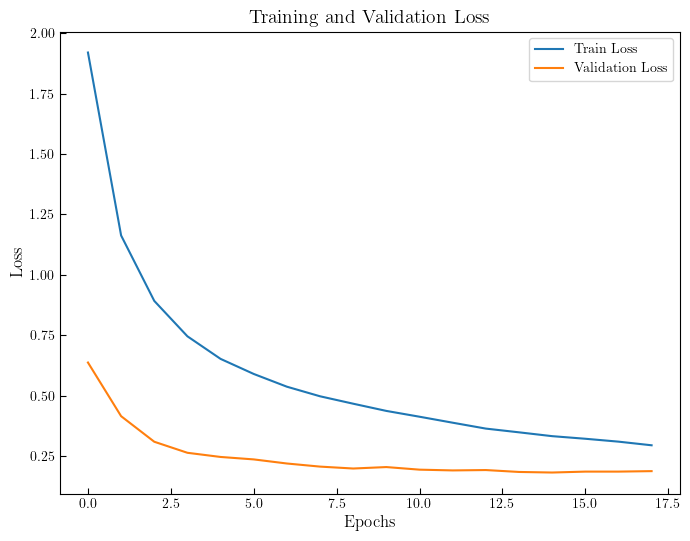

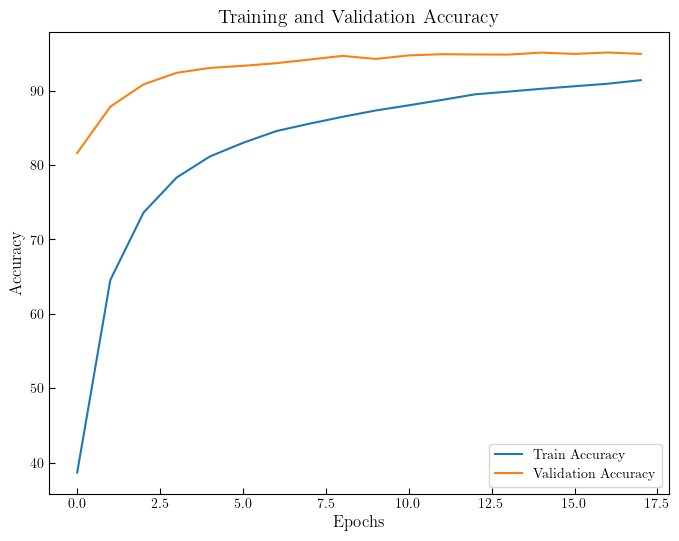

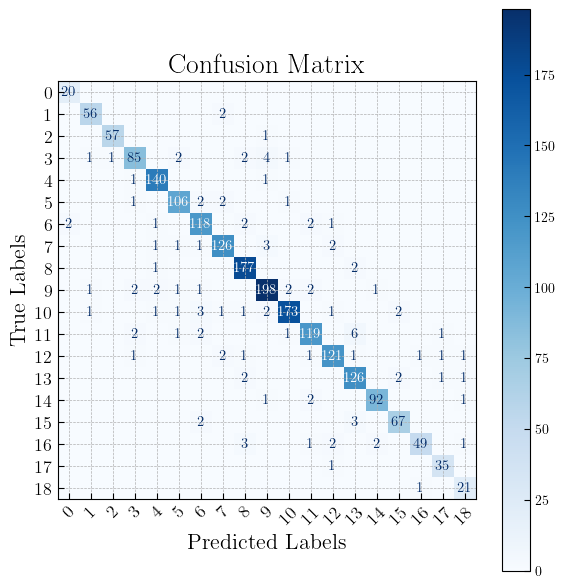

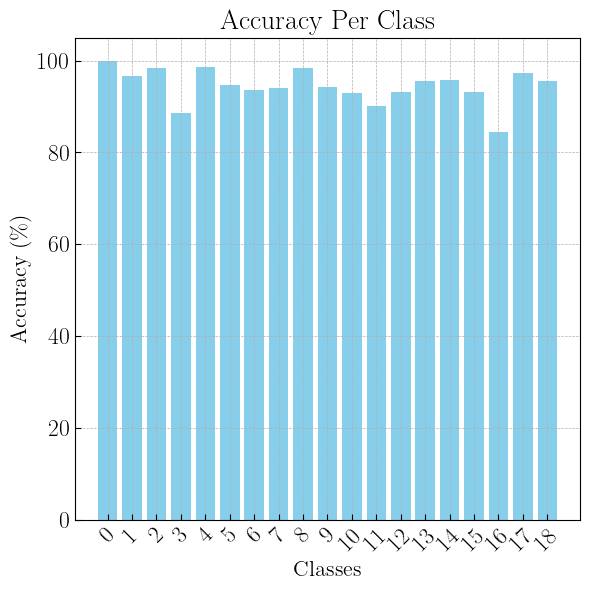

Best Model Validation Accuracy: 95.12%
Best Model Test Accuracy: 94.30%
Global Best Hyperparameters: {'num_layers': 5, 'initial_neurons': 557, 'reduction_factor': 0.6226515278496167, 'dropout_rate': 0.1669743228795801, 'lr': 0.0009173826786868063, 'batch_size': 64, 'activation_function': 'ReLU', 'optimizer': 'RMSprop'}


In [9]:
# Evaluate and get the best model
best_model, results = evaluate_and_plot_best_model(
    study=global_study_dynamic,  
    train_dataset=train_dataset,  
    val_dataset=val_dataset,      
    test_dataset=test_dataset,    
    num_classes=19,               
    
)

print("Global Best Hyperparameters:", global_study_dynamic.best_params)


### Optimize t-SNE Perplexity and Visualize Embeddings

- **Step 1: Extract Embeddings**:
  - Extract embedding representations from the best neural network using the test dataset.
  - These embeddings represent the output of the last hidden layer before the final classification layer.

- **Step 2: Prepare Raw Input Data**:
  - Flatten the raw input test data and prepare corresponding labels for comparison with embeddings.

- **Step 3: Optimize t-SNE Perplexity**:
  - Use `optimize_tsne_silhouette` to find the optimal perplexity for t-SNE by maximizing the silhouette score.
  - Test a range of perplexity values for both the embedding layer and raw input data.
  - Compute silhouette scores for each perplexity and select the best one based on the highest score.

- **Step 4: Visualize Best t-SNE Results**:
  - Generate a 2D t-SNE visualization for the embedding layer using the best perplexity.
  - Plot the t-SNE results to observe the separability of classes based on their embeddings.

Key Outputs:
- The best perplexity value and corresponding silhouette score for the embedding layer.
- A t-SNE plot showcasing the embedding layer's 2D representation, color-coded by class labels.


Using 7 workers for DataLoader.
Best Silhouette Perplexity (Embedding): 50, Score: 0.3925


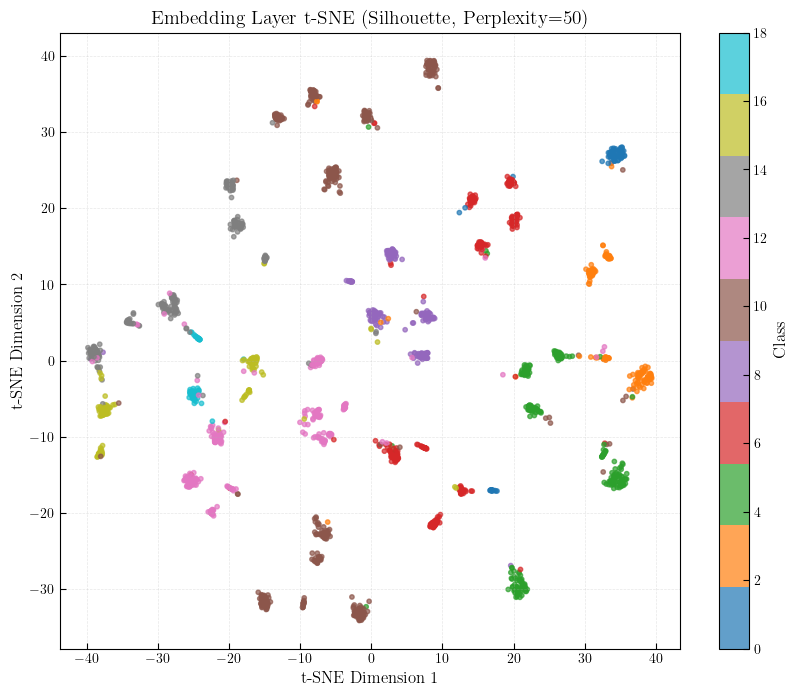

In [10]:
from collections import defaultdict
from sklearn.metrics import silhouette_score

# Step 1: Extract Embeddings from the Best Neural Network
_, _, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=128)
embedding_data, embedding_labels = extract_embeddings(best_model, test_loader, device)

# Step 2: Prepare Raw Input Data
raw_input_data = np.vstack([x.numpy().flatten() for x, _ in test_dataset])
raw_input_labels = np.array([y.numpy() for _, y in test_dataset])

# Step 3: Evaluate and Optimize Perplexity using Silhouette Score
def optimize_tsne_silhouette(data, labels, perplexity_values):

    silhouette_scores = {}
    for perplexity in perplexity_values:
        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        data_2d = tsne.fit_transform(data)
        
        # Compute silhouette score
        score = silhouette_score(data_2d, labels)
        silhouette_scores[perplexity] = score
    
    # Find the best perplexity
    best_perplexity = max(silhouette_scores, key=silhouette_scores.get)
    best_score = silhouette_scores[best_perplexity]
    
    return silhouette_scores, (best_perplexity, best_score)

# Perplexity values to test (adjusted for better results)
perplexity_values = [5, 10, 20, 30, 40, 50]

# Optimize t-SNE for embedding layer
embedding_scores, best_silhouette_embedding = optimize_tsne_silhouette(
    embedding_data, embedding_labels, perplexity_values
)

# Optimize t-SNE for raw input
raw_scores, best_silhouette_input = optimize_tsne_silhouette(
    raw_input_data, raw_input_labels, perplexity_values
)

# Step 4: Plot Best t-SNE Visualizations (Based on Silhouette Score)
# Best for Embedding Layer
print(f"Best Silhouette Perplexity (Embedding): {best_silhouette_embedding[0]}, Score: {best_silhouette_embedding[1]:.4f}")
best_embedding_tsne = TSNE(n_components=2, perplexity=best_silhouette_embedding[0], random_state=42).fit_transform(embedding_data)
plot_tsne(best_embedding_tsne, embedding_labels, f"Embedding Layer t-SNE (Silhouette, Perplexity={best_silhouette_embedding[0]})")

Best Silhouette Perplexity (Input): 10, Score: -0.1984


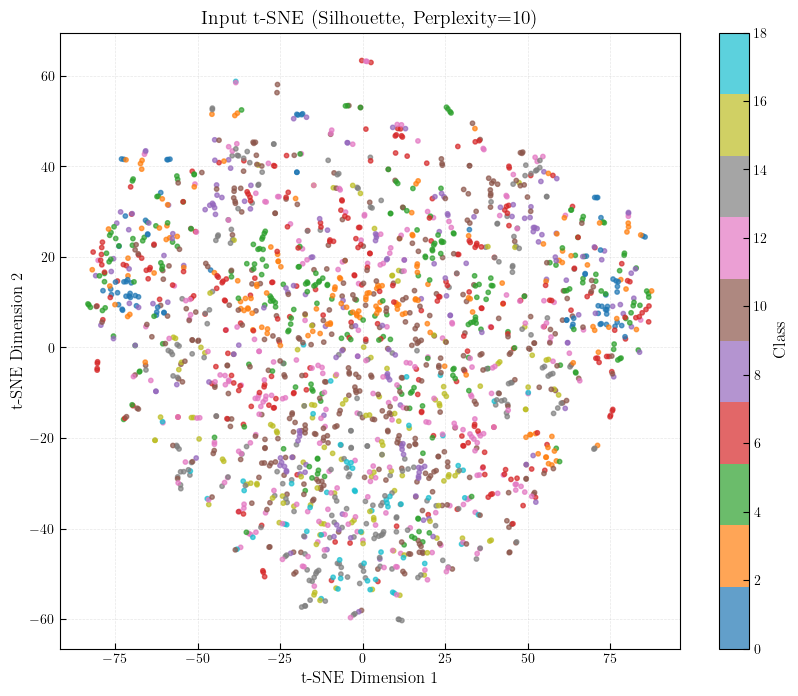

In [11]:
# Best for Raw Input
print(f"Best Silhouette Perplexity (Input): {best_silhouette_input[0]}, Score: {best_silhouette_input[1]:.4f}")
best_input_tsne = TSNE(n_components=2, perplexity=best_silhouette_input[0], random_state=42).fit_transform(raw_input_data)
plot_tsne(best_input_tsne, raw_input_labels, f"Input t-SNE (Silhouette, Perplexity={best_silhouette_input[0]})")